# Non-covalent interactions benchmark

In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local'  # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Non-covalent interactions benchmark'
parallel = None  # how many jobs to run at once

In [3]:
methods = {"HF": "df-hf", "MP2": "df-mp2", "LMP2": "df-lmp2", }
bases = ['aug-cc-pVDZ', 'aug-cc-pVTZ', 'aug-cc-pVQZ']

In [4]:
db = pymolpro.database.library("GMTKN55_S22").subset('small')

In [5]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(db, methods[method], basis, location=project_name,
                                                       backend=backend, parallel=parallel)

In [6]:
extrapolations = {}
if 'aug-cc-pVDZ' in bases and 'aug-cc-pVTZ' in bases:
    extrapolations["aug-cc-pV[23]Z"] = {'x': 2, 'first': 'aug-cc-pVDZ', 'second': 'aug-cc-pVTZ'}
if 'aug-cc-pVTZ' in bases and 'aug-cc-pVQZ' in bases:
    extrapolations["aug-cc-pV[34]Z"] = {'x': 3, 'first': 'aug-cc-pVTZ', 'second': 'aug-cc-pVQZ'}
if 'aug-cc-pVQZ' in bases and 'aug-cc-pV5Z' in bases:
    extrapolations["aug-cc-pV[45]Z"] = {'x': 4, 'first': 'aug-cc-pVQZ', 'second': 'aug-cc-pV5Z'}

for extr in extrapolations:
    x = extrapolations[extr]['x']
    xbas = extrapolations[extr]['first']
    xpbas = extrapolations[extr]['second']
    for method in methods:
        results[method][extr] = pymolpro.database.basis_extrapolate(
            [results[method][xbas], results[method][xpbas]],
            [results['HF'][xbas], results['HF'][xpbas]],
            [x, x + 1]
        )
    bases.append(extr) if extr not in bases else ""


In [7]:
tokj = 2625.49963948
pd.set_option('display.precision', 2)
method_errors = pymolpro.database.analyse([results[method]['aug-cc-pVQZ'] for method in methods], db)[
                    'reaction statistics'] * tokj
method_errors

,DF-HF,DF-MP2,DF-LMP2
,aug-cc-pVQZ,aug-cc-pVQZ,aug-cc-pVQZ
mean,-6.08,0.22,-0.54
stdev,2.03,0.21,0.26
meanabs,6.08,0.22,0.54
maxabs,7.52,0.42,0.79


In [8]:
for key, table in pymolpro.database.analyse([results[method]['aug-cc-pVQZ'] for method in methods], db).items():
    print(key)
    print(table)

reaction energies
        DF-HF      DF-MP2     DF-LMP2
  aug-cc-pVQZ aug-cc-pVQZ aug-cc-pVQZ
2    5.30e-03    8.11e-03    7.65e-03
1    2.13e-03    5.09e-03    4.78e-03
8   -5.94e-04    8.36e-04    7.38e-04
reaction energy errors
        DF-HF      DF-MP2     DF-LMP2
  aug-cc-pVQZ aug-cc-pVQZ aug-cc-pVQZ
2   -2.65e-03    1.59e-04   -3.02e-04
1   -2.87e-03    9.25e-05   -2.12e-04
8   -1.43e-03   -3.85e-06   -1.02e-04
reaction statistics
              DF-HF      DF-MP2     DF-LMP2
        aug-cc-pVQZ aug-cc-pVQZ aug-cc-pVQZ
mean      -2.32e-03    8.25e-05   -2.05e-04
stdev      7.72e-04    8.18e-05    9.99e-05
meanabs    2.32e-03    8.51e-05    2.05e-04
maxabs     2.87e-03    1.59e-04    3.02e-04
molecule energies
          DF-HF      DF-MP2     DF-LMP2
    aug-cc-pVQZ aug-cc-pVQZ aug-cc-pVQZ
02      -152.14     -152.71     -152.71
08       -80.43      -80.86      -80.85
01      -112.45     -112.96     -112.96
01a      -56.22      -56.48      -56.48
02a      -76.07      -76.35      -76.

In [9]:
tokj = 2625.49963948
pd.set_option('display.precision', 2)
method_errors = pymolpro.database.analyse([results[method]['aug-cc-pVQZ'] for method in methods], db)[
                    'reaction energy errors'] * tokj
method_errors

,DF-HF,DF-MP2,DF-LMP2
,aug-cc-pVQZ,aug-cc-pVQZ,aug-cc-pVQZ
2,-6.96,0.42,-0.79
1,-7.52,0.24,-0.56
8,-3.76,-0.01,-0.27


In [10]:
pd.set_option('display.precision', 2)
basis_errors = pymolpro.database.analyse([results['LMP2'][basis] for basis in bases], db)[
                   'reaction statistics'] * tokj
basis_errors

DF-LMP2                                                      
        aug-cc-pVDZ aug-cc-pVTZ aug-cc-pVQZ aug-cc-pV[23]Z aug-cc-pV[34]Z
mean          -1.21       -4.05       -0.54          -4.85           2.07
stdev          1.36        5.71        0.26           7.71           3.80
meanabs        1.44        4.05        0.54           4.85           2.24
maxabs         2.23       10.62        0.79          13.76           6.46

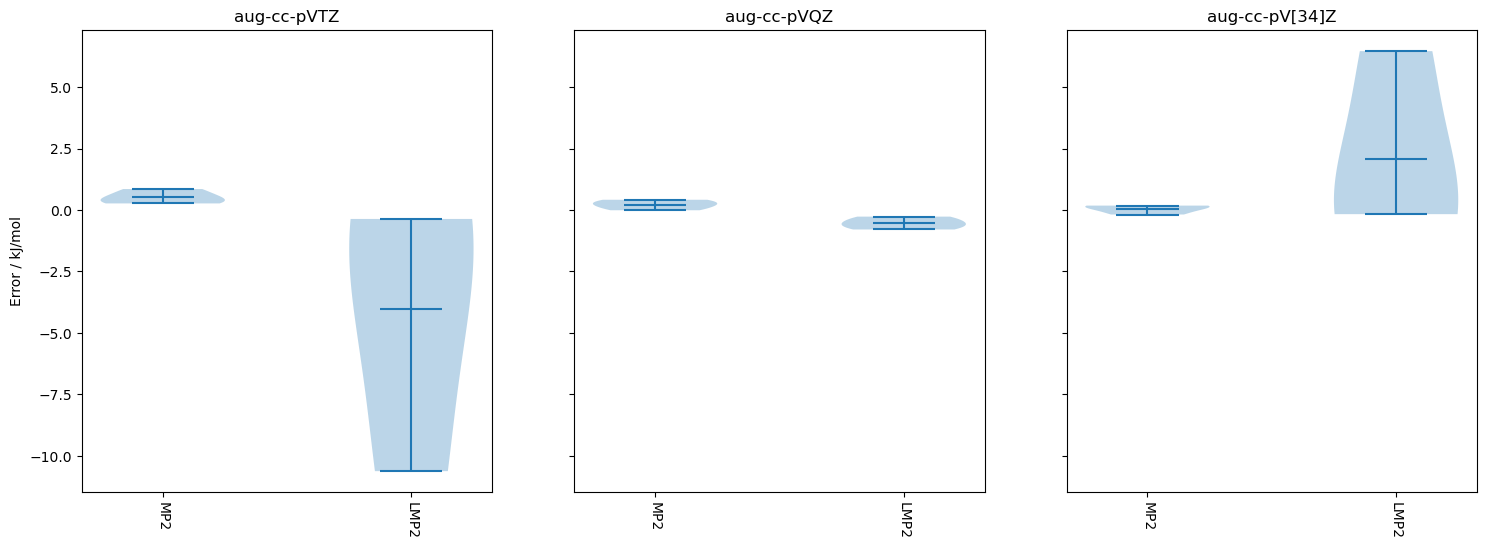

In [11]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['aug-cc-pVTZ', 'aug-cc-pVQZ', 'aug-cc-pV[34]Z']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                      db)['reaction energy errors'].to_numpy()[:, 0] * tokj
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")

In [12]:
# with open(project_name + '.tex', 'w') as tf:
#     tf.write('\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}')
#     tf.write(df_exp_reaction_meanerror.style.to_latex())
#     tf.write(df_exp_reaction_std.style.to_latex())
#     tf.write(df_exp_reaction_meanabserror.style.to_latex())
#     tf.write(df_exp_reaction_maxerror.style.to_latex())